**Gabriela Tanumihardja**</br>
**Capstone Project - Part VI** </br>
**Deep Learning - BERT**

In this section I would like to begin my exploration into deep learning. I will use transfer learning using the Google's pretrained BERT model. I attempted to train this model on my personal laptop, however it was taking quite a while. Because of this, I will be training my model using Google Colab. The code from this notebook is adapted from Google's tutorial on using BentoML and BERT for tf2. The tutorial is licensed under the Apache License v.2.
https://colab.research.google.com/github/bentoml/gallery/blob/master/tensorflow/bert/bert_movie_reviews.ipynb#scrollTo=dCpvgG0vwXAZ</br>
http://www.apache.org/licenses/LICENSE-2.0

In [18]:
# Install tqdm, BERT for tensorflow2

!pip install -q tqdm bert-for-tf2

In [19]:
# Mount google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
import os
import re
import sys
import math
import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

In [21]:
# Check versions

print("Tensorflow: ", tf.__version__)
print("Python: ", sys.version)
print("GPU: ", tf.test.is_gpu_available())
assert sys.version_info.major == 3 and sys.version_info.minor == 6  # required by clipper benchmark

Tensorflow:  2.3.0
Python:  3.6.9 (default, Jul 17 2020, 12:50:27) 
[GCC 8.4.0]
GPU:  True


I will first load in the data

In [24]:
# Load data from Google drive

train_df = pd.read_csv('/content/drive/My Drive/CAPSTONE/BERT/data/train.csv')
test_df = pd.read_csv('/content/drive/My Drive/CAPSTONE/BERT/data/test.csv')

From this point, I will be using BERT's tokenizer, padding/trim the length of each headline to max_seq_length, I will also append BERT' special [CLS] and [SEP] token at the start and at the end of each entry. These tokens also need to be converted to numerical IDs using BERT's vocab.txt file.

In [25]:
import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights

# Create a class for data preprocessing

class SatireData:
    # Name of column for the X
    DATA_COLUMN = "title"
    
    # Name of column for the y
    LABEL_COLUMN = "satire"
    
    def __init__(self, tokenizer: FullTokenizer, sample_size=None, max_seq_len=1024):
        self.tokenizer = tokenizer
        self.sample_size = sample_size
        self.max_seq_len = 0

        train, test = train_df, test_df
        
        train, test = map(lambda df: df.reindex(df[SatireData.DATA_COLUMN].str.len().sort_values().index), 
                          [train, test])
                
        if sample_size is not None:
            train, test = train.head(sample_size), test.head(sample_size)
            
        ((self.train_x, self.train_y),
         (self.test_x, self.test_y)) = map(self._prepare, [train, test])

        # If the data's max seq_len is less than 1024, use that number instead
        print("max seq_len", self.max_seq_len)
        self.max_seq_len = min(self.max_seq_len, max_seq_len)
        ((self.train_x, self.train_x_token_types),
         (self.test_x, self.test_x_token_types)) = map(self._pad, 
                                                       [self.train_x, self.test_x])

    def _prepare(self, df):
        x, y = [], []
        with tqdm(total=df.shape[0], unit_scale=True) as pbar:
            for ndx, row in df.iterrows():
                text, label = row[SatireData.DATA_COLUMN], row[SatireData.LABEL_COLUMN]
                tokens = self.tokenizer.tokenize(text)
                # [CLS] [SEP] sandwhich
                tokens = ["[CLS]"] + tokens + ["[SEP]"]
                token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
                self.max_seq_len = max(self.max_seq_len, len(token_ids))
                x.append(token_ids)
                y.append(int(label))
                pbar.update()
        return np.array(x), np.array(y)

    def _pad(self, ids):
        # pad any entries less than max seq_len to max seq_len
        x, t = [], []
        token_type_ids = [0] * self.max_seq_len
        for input_ids in ids:
            input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
            input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
            x.append(np.array(input_ids))
            t.append(token_type_ids)
        return np.array(x), np.array(t)


I have downloaded base BERT model onto my Google drive. It was downloaded from:
https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip </br>
I will now load in the pre-trained model.

In [26]:
bert_model_name="uncased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("/content/drive/My Drive/CAPSTONE/BERT/model", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

#### Data Preprocessing

I will now put through all my data through the tokenizer. I will use a maximum of 128 tokens, or lower if my data's actual max sequence is lower than 128. I will also use all of my training data.

In [27]:
%%time

tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))
data = SatireData(tokenizer,
                       max_seq_len=128)

100%|██████████| 27.8k/27.8k [00:08<00:00, 3.44kit/s]
100%|██████████| 6.95k/6.95k [00:01<00:00, 3.49kit/s]


max seq_len 66
CPU times: user 10.5 s, sys: 88.1 ms, total: 10.6 s
Wall time: 10.6 s


In [28]:
print("            train_x", data.train_x.shape)
print("train_x_token_types", data.train_x_token_types.shape)
print("            train_y", data.train_y.shape)

print("             test_x", data.test_x.shape)

print("        max_seq_len", data.max_seq_len)

            train_x (27788, 66)
train_x_token_types (27788, 66)
            train_y (27788,)
             test_x (6948, 66)
        max_seq_len 66


The data's max_seq_len is 66 words, so that's what will be used in the model training. I will be training the entire BERT layers with my data, so the I will not be using the freeze_bert_layer function. For training, a learning rate scheduler will also be instantiated. A warm up phase will also be instantiated. Initally the training rate will be higher, making larger changes, and reduce per epoch, making finer adjustments.

In [29]:
def flatten_layers(root_layer):
    if isinstance(root_layer, keras.layers.Layer):
        yield root_layer
    for layer in root_layer._layers:
        for sub_layer in flatten_layers(layer):
            yield sub_layer


def freeze_bert_layers(l_bert):
    for layer in flatten_layers(l_bert):
        if layer.name in ["LayerNorm", "adapter-down", "adapter-up"]:
            layer.trainable = True
        elif len(layer._layers) == 0:
            layer.trainable = False
        l_bert.embeddings_layer.trainable = False

        
def create_learning_rate_scheduler(max_learn_rate=5e-5,
                                   end_learn_rate=1e-7,
                                   warmup_epoch_count=10,
                                   total_epoch_count=90):

    def lr_scheduler(epoch):
        if epoch < warmup_epoch_count:
            res = (max_learn_rate/warmup_epoch_count) * (epoch + 1)
        else:
            res = max_learn_rate*math.exp(
                math.log(end_learn_rate/max_learn_rate)*(epoch-warmup_epoch_count+1)/(total_epoch_count-warmup_epoch_count+1))
        return float(res)
    learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)

    return learning_rate_scheduler


From here I will assemble my model, and add a layer of softmax to give the final classification probability. This function will also load the the pre-trained BERT model. Finally the function will return the compiled model.

In [30]:
def create_model(max_seq_len, adapter_size=64):
    
    with tf.io.gfile.GFile(bert_config_file, "r") as reader:
        bc = StockBertConfig.from_json_string(reader.read())
        bert_params = map_stock_config_to_params(bc)
        bert_params.adapter_size = adapter_size
        bert = BertModelLayer.from_params(bert_params, name="bert")

    input_ids      = keras.layers.Input(shape=(max_seq_len,), dtype='int32', name="input_ids")
    output         = bert(input_ids)

    print("bert shape", output.shape)
    cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(output)
    cls_out = keras.layers.Dropout(0.5)(cls_out)
    logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
    logits = keras.layers.Dropout(0.5)(logits)
    logits = keras.layers.Dense(units=2, activation="softmax")(logits)

    model = keras.Model(inputs=input_ids, outputs=logits)
    model.build(input_shape=(None, max_seq_len))

    # load the pre-trained model weights
    load_stock_weights(bert, bert_ckpt_file)

    # freeze weights if adapter-BERT is used
    if adapter_size is not None:
        freeze_bert_layers(bert)

    model.compile(optimizer=keras.optimizers.Adam(),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")])

    model.summary()

    return model

Compiling model

In [31]:
adapter_size = None
model = create_model(data.max_seq_len, adapter_size=adapter_size)

bert shape (None, 66, 768)
Done loading 196 BERT weights from: /content/drive/My Drive/CAPSTONE/BERT/model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f771bbedbe0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 66)]              0         
_________________________________________________________________
bert (Bert

The final compiled model will train all 110,000,000 parameters. I will now start the model. I also have passed in an early stop to avoid overfitting

In [32]:
%%time

log_dir = ".log/satire_class/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

total_epoch_count = 10
history = model.fit(x=data.train_x, y=data.train_y,
          validation_split=0.1,
          batch_size=12,
          shuffle=True,
          epochs=total_epoch_count,
          callbacks=[create_learning_rate_scheduler(max_learn_rate=1e-5,
                                                    end_learn_rate=1e-7,
                                                    warmup_epoch_count=20,
                                                    total_epoch_count=total_epoch_count),
                     keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
                     tensorboard_callback])


Epoch 00001: LearningRateScheduler reducing learning rate to 5.000000000000001e-07.
Epoch 1/10
2085/2085 [==============================] - 816s 391ms/step - loss: 0.6685 - acc: 0.5941 - val_loss: 0.5620 - val_acc: 0.7337

Epoch 00002: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
Epoch 2/10
2085/2085 [==============================] - 830s 398ms/step - loss: 0.5543 - acc: 0.7429 - val_loss: 0.4557 - val_acc: 0.8499

Epoch 00003: LearningRateScheduler reducing learning rate to 1.5000000000000002e-06.
Epoch 3/10
2085/2085 [==============================] - 815s 391ms/step - loss: 0.4851 - acc: 0.8192 - val_loss: 0.4362 - val_acc: 0.8694

Epoch 00004: LearningRateScheduler reducing learning rate to 2.0000000000000003e-06.
Epoch 4/10
2085/2085 [==============================] - 818s 392ms/step - loss: 0.4485 - acc: 0.8594 - val_loss: 0.4004 - val_acc: 0.9122

Epoch 00005: LearningRateScheduler reducing learning rate to 2.5000000000000006e-06.
Epoch 5/10
2085/208

In [58]:
%config InlineBackend.figure_format='retina'

Very good validation accuracy from this model, at 92%. I will now plot the loss vs epoch and accuracy vs epoch to evaluate the training process.

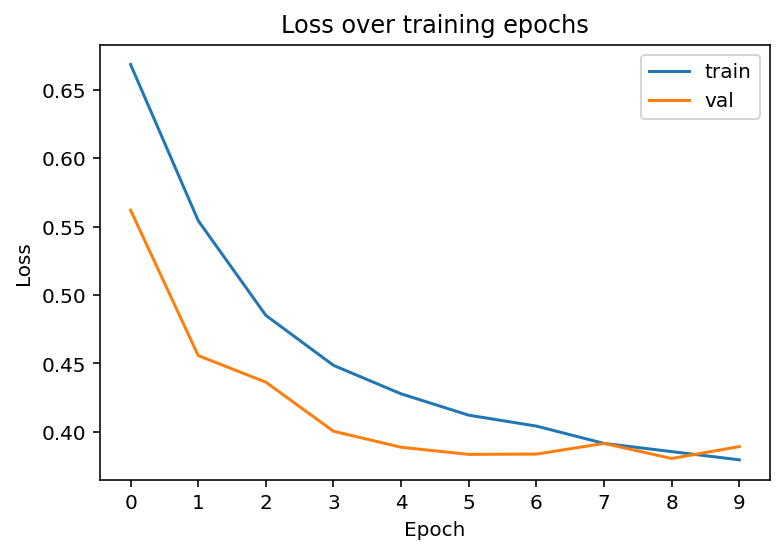

In [59]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'])
plt.title('Loss over training epochs')
plt.show();

From the above graph above, the training loss decreased significantly in the earlier epochs and from around epoch 6, there was no more significant loss in model error. From the above graph, I would say that the number epoch I chose is appropriate, if not a little too high.

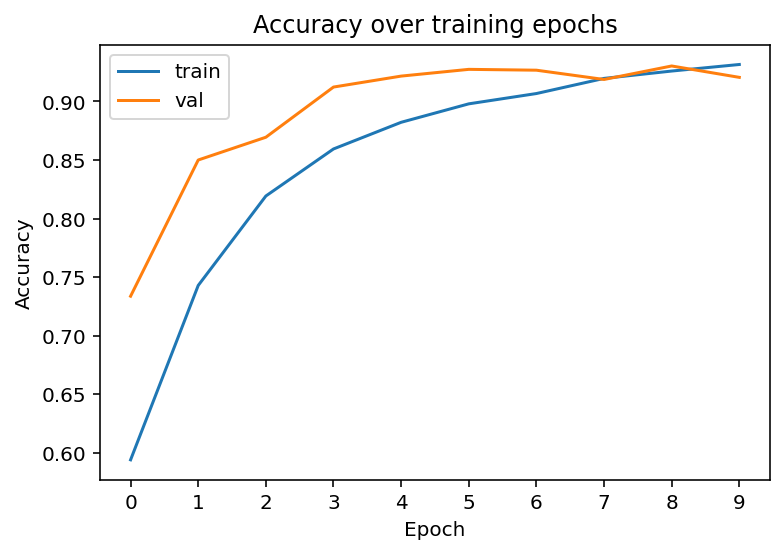

In [60]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'])
plt.title('Accuracy over training epochs')
plt.show();

From graph above, it can be seen that the gain in validation accuracy increased tremendously over the first 4 epochs, where it started to plateau. At the end of the training period, there was no more increase in validation accuracy. I will now test this model agaisnt the test set.

In [36]:
%%time

_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc", train_acc)
print(" test acc", test_acc)

218/218 [==============================] - 36s 166ms/step - loss: 0.4142 - acc: 0.8962
train acc 0.94745934009552
 test acc 0.8962291479110718
CPU times: user 1min 1s, sys: 10.8 s, total: 1min 12s
Wall time: 3min 2s


The test accuracy is around 90%, compared to 95% of validation accuracy. There is not a very significant difference between the two accuracies, indicating that the model is possibly not overfitted, and if so, not so bad. I would like to extract the weights from this model to be used another time, on my local system.

In [56]:
# Saving weights

model.save_weights('/bert_final_bin.h5', overwrite=True)

In [57]:
# I will now load the model and test

loaded_model = create_model(data.max_seq_len, adapter_size=None)
loaded_model.load_weights("/bert_final_bin.h5")

bert shape (None, 66, 768)
Done loading 196 BERT weights from: /content/drive/My Drive/CAPSTONE/BERT/model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f756c822cc0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 66)]              0         
_________________________________________________________________
bert (Bert

In [42]:
%%time 

# _, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = loaded_model.evaluate(data.test_x, data.test_y)

# print("train acc", train_acc)
print(" test acc", test_acc)


y_pred = loaded_model.predict(data.test_x).argmax(axis=-1)

218/218 [==============================] - 37s 167ms/step - loss: 0.4142 - acc: 0.8962
 test acc 0.8962291479110718
CPU times: user 24 s, sys: 4.14 s, total: 28.2 s
Wall time: 1min 12s


We have the exact same results from the loaded model as the original model. I will now evaluate the model by creating a classification report and confusion matrix. I will use the test set to create these evaluations.

In [43]:
# print classification report

from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(data.test_y, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      3029
           1       0.95      0.86      0.90      3919

    accuracy                           0.90      6948
   macro avg       0.89      0.90      0.90      6948
weighted avg       0.90      0.90      0.90      6948



In [47]:
# create confusion matrix

group = train_df.satire.unique().tolist()

cm = confusion_matrix(data.test_y, y_pred)

df_cm = pd.DataFrame(cm, index=group, columns=group)

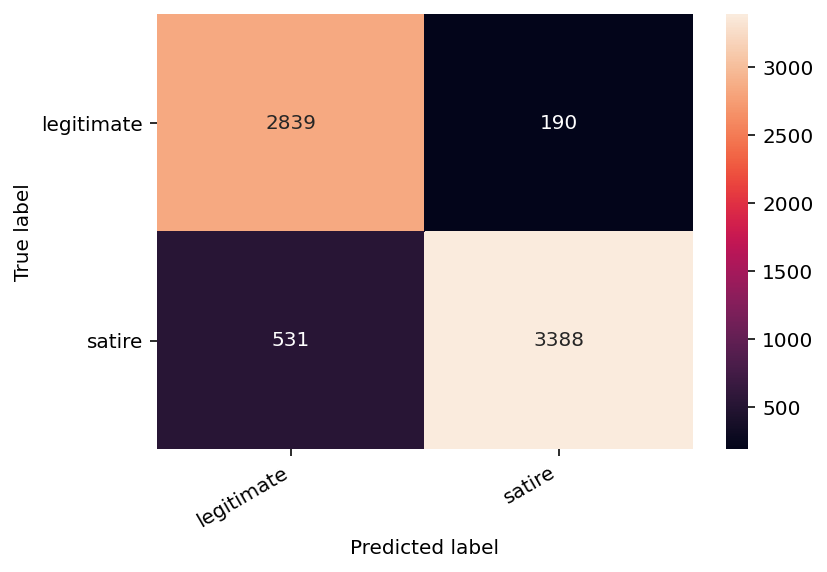

In [61]:
# make heatmap

import seaborn as sns

hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(['legitimate', 'satire'], rotation=0, ha='right')
hmap.xaxis.set_ticklabels(['legitimate', 'satire'], rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

From the heatmap above, I could see that there is a much higher rate of false negative than false positive. The overall accuracy of this model is 90%, same with recall and precision. From here, I would like to be able to insert custom sentences into our model. The following code will tokenize, make a [CLS] [SEP] sandwhich, convert tokens to IDs, and feed these tokens into the loaded model. 

In [ ]:
%%time
CLASSES = ["legitimate","satire"]
max_seq_len = 128
pred_sentences = [
  "premier ford outraged federal government not doing his job",
  "vancouver experiencing severe mothman infestation",
  "most of B.C. now warned of smoky skies and lower air quality from U.S. wildfires",
  "17 dead and dozens missing as western wildfires rage",
]

inputs = pd.DataFrame(pred_sentences)

pred_tokens    = map(tokenizer.tokenize, inputs.to_numpy()[:, 0].tolist())
pred_tokens    = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))
pred_token_ids = map(lambda tids: tids + [0] * (max_seq_len-len(tids)), pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))

res = loaded_model(pred_token_ids).numpy().argmax(axis=-1)
print([CLASSES[i] for i in res])

The model made good predictions for my custom headlines. I will now save the whole model to create an app. I will then download the model to my local computer.

In [67]:
model.save('/content/drive/My Drive/CAPSTONE/final_binary_model')

INFO:tensorflow:Assets written to: /content/drive/My Drive/CAPSTONE/final_binary_model/assets
